# Mini Use Case Autoencoder 

Hier befindet sich der [Beispielcode](./miniUsecase_19_ConvAutoenc_.ipynb) für das Implementieren eines Autoencoders um ein ML-Modell zu trainieren. Dieser Code ist ähnlich aufgebaut wieder Use-Case der Support Vector Machine [(SVM)](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Support_Vector_Machine_fuer_Bildklassifizierung). Wir wollen Bildern klassifizieren. Genauer gesagt, wollen wir herausfinden welche Zahl auf einem Bild ist. 

In dem Use-Case der SVM haben wir uns auf das Modell konzentriert allerdings und besprochen wie mittels der Hauptkomponentenanalyse (PCA) dieses trainiert werden kann. Diesmal beschäftigen wir uns mit einem bisschen komplexeren Modell und werden anstatt der PCA den Autoencoder einsetzen. 

In [1]:
# Importieren der notwendigen Bibliotheken 
import numpy 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

## Daten Einlesen
Der notwendige Datensatz wird hier als CSV-Datei eingelesen. Hierzu werden 2 Datensätze benötigt, welche heruntergeladen werden müssen: </br>
Teil 1: [Trainingsset](https://pjreddie.com/media/files/mnist_train.csv)
</br>
Teil 2: [Testset](https://pjreddie.com/media/files/mnist_test.csv) 

Die Datensätze müssen anschließend in dem Ordner abgelegt werden, aus dem dieses Notebook ausgeführt wird.

In [2]:
# Insgesamt 10000 
X_test_AE  = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(1,785), max_rows=5000)
X_test_SVM = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=5000)
Y_test_AE  = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(0,1), max_rows=5000)
Y_test_SVM = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(0,1), skiprows=5000)

# Insgesamt 60000 
X_train_AE   = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), max_rows=30000)
X_train_SVM  = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=30000, max_rows=29995)
X_evaluation = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=(30000+29995))

Y_train_AE   = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(0,1),max_rows=30000)
Y_train_SVM  = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(0,1), skiprows=30000, max_rows=29995)
Y_evaluation = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=(30000+29995))


In [3]:
# Convert for Training 
X_test_AE    = X_test_AE.reshape(-1, 28, 28)
X_test_SVM   = X_test_SVM.reshape(-1, 28, 28)
X_train_AE   = X_train_AE.reshape(-1, 28, 28)
X_train_SVM  = X_train_SVM.reshape(-1, 28, 28)
X_evaluation = X_evaluation.reshape(-1, 28, 28)

In [4]:

print("********** Dataset overview *************")
# Autoencoder Dataset 
print("Test Data Autoencoder:        {}".format( X_test_AE.shape))
print("Test Labels Autoencoder:     {}".format(  Y_test_AE.shape))
print("Train Data Autoencoder:       {}".format(X_train_AE.shape))
print("Train Labels Autoencoder:    {}".format( Y_train_AE.shape))
print("*****************************************")
# SVM Dataset 
print("Test Data SVM:        {}".format( X_test_SVM.shape))
print("Test Labels SVM:     {}".format(  Y_test_SVM.shape))
print("Train Data SVM:       {}".format(X_train_SVM.shape))
print("Train Labels SVM:    {}".format( Y_train_SVM.shape))
print("*****************************************")
#Evaluation (5 Bilder)
print("Evaluation Set:      {}".format(X_evaluation.shape))
print("*****************************************")

********** Dataset overview *************
Test Data Autoencoder:        (5000, 28, 28)
Test Labels Autoencoder:     (5000,)
Train Data Autoencoder:       (30000, 28, 28)
Train Labels Autoencoder:    (30000,)
*****************************************
Test Data SVM:        (5000, 28, 28)
Test Labels SVM:     (5000,)
Train Data SVM:       (29995, 28, 28)
Train Labels SVM:    (29995,)
*****************************************
Evaluation Set:      (5, 28, 28)
*****************************************


In [5]:
# anpassen für Tensorflow
# AE
X_train_AE = X_train_AE.astype('float32') / 255.
X_test_AE=  X_test_AE.astype('float32') / 255.

# SVM
X_train_SVM = X_train_SVM.astype('float32') / 255.
X_test_SVM =  X_test_SVM.astype('float32') / 255.


## Autoencoder

[Autoencoder Source](https://www.tensorflow.org/tutorials/generative/autoencoder)



![Aufbau](aufbau.png)

In [6]:
latent_dim = 49 #64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

2022-03-08 12:45:21.976376: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-08 12:45:21.997551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 12:45:21.997791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-03-08 12:45:21.997967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-03-08 12:45:21.998079: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10'; dlerror: libcublas.so.10: cannot open shared object file:

In [8]:
autoencoder.fit(X_train_AE, X_train_AE,
                epochs=10,
                shuffle=True,
                validation_data=(X_test_AE, X_test_AE))


Epoch 1/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0386 - val_loss: 0.0211
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0156 - val_loss: 0.0123
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 8/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 9/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 10/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0063

In [9]:
encoded_imgs = autoencoder.encoder(X_test_AE).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

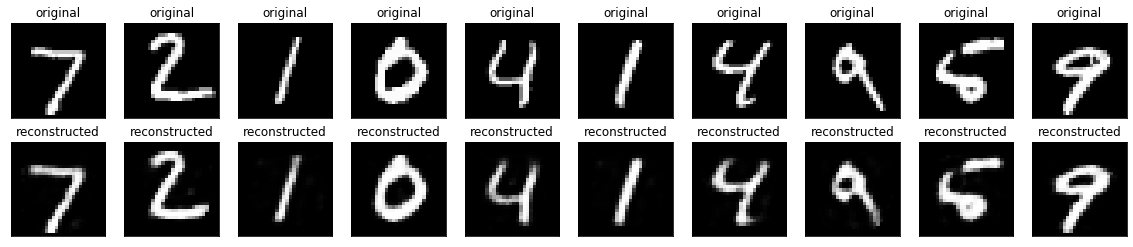

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test_AE[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## SVM
[Storyboard](http://www.aiav.technikum-wien.at/) </br>
[GitHub](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Support_Vector_Machine_fuer_Bildklassifizierung) </br>

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [12]:
# Encoder für das reduzieren der Dimensionen.
X_train = autoencoder.encoder(X_train_SVM).numpy()
X_test = autoencoder.encoder(X_test_SVM).numpy()
y_train = Y_train_SVM
y_test = Y_test_SVM



print("********** Dataset overview *************")
# Autoencoder Dataset 
print("Train Data fuer SVM Encoded:   {}".format(X_train.shape))
print("Test  Data fuer SVM Encoded:   {}".format( X_test.shape))
print("Train Labels SVM:                           {}".format( y_train.shape))
print("Test  Labels SVM:                           {}".format(  y_test.shape))
print("*****************************************")


********** Dataset overview *************
Train Data fuer SVM Encoded:   (29995, 49)
Test  Data fuer SVM Encoded:   (5000, 49)
Train Labels SVM:                           (29995,)
Test  Labels SVM:                           (5000,)
*****************************************


In [13]:
# Modell definieren und 
svm = SVC(kernel='linear', probability=True, random_state=42)       # SVM Definition
svm.fit(X_train, y_train)                                           # Modell Trainieren

SVC(kernel='linear', probability=True, random_state=42)

# Evaluieren und Testen

In [14]:
y_pred = svm.predict(X_test)                     # Prediction für den Test Datensatz
accuracy = accuracy_score(y_test, y_pred)        # Auswertung
print('Model accuracy: ', accuracy)              # Ausgabe der Genauigkeit

Model accuracy:  0.9564


In [15]:
import cv2
X_evaluation_AE  = X_evaluation.astype('float32') / 255.
encodes_evaluation = autoencoder.encoder(X_evaluation_AE).numpy()
decoded_evaluation = autoencoder.decoder(encodes_evaluation).numpy()



evaluation_pred = svm.predict(encodes_evaluation)
cv2.namedWindow("Image for prediction", 0)
cv2.namedWindow("Reconstructed Image", 0)
for i in range(X_evaluation.shape[0]):

    print("Auf dem Bild ist eine {} zu sehen".format(evaluation_pred[i]))
    cv2.imshow("Image for prediction", X_evaluation[i])
    cv2.imshow("Reconstructed Image", decoded_evaluation[i])
    cv2.waitKey(0)
    
cv2.destroyAllWindows()


Auf dem Bild ist eine 8.0 zu sehen
Auf dem Bild ist eine 3.0 zu sehen
Auf dem Bild ist eine 5.0 zu sehen
Auf dem Bild ist eine 6.0 zu sehen
Auf dem Bild ist eine 8.0 zu sehen
